ASKCOS is publicly available at https://askcos.mit.edu/. The tool's algorithms are avilable for review in the folder attached with the manuscript. Key dependencies include rdkit and rdchiral (https://pypi.org/project/rdchiral/)

# 1. Chemoenzymatic synthesis algorithm

In [1]:
import pandas as pd
from typing import List, Tuple
from rdchiral.initialization import rdchiralReaction, rdchiralReactants
from rdchiral.main import rdchiralRun
import os

class parse_askcos_output:
    '''Parse the results of the tree search'''
    
    def __init__(self):
        
        #get tree input
        self.askcos_output = None
        
        #load template set
        self.template_set= pd.read_pickle(os.getcwd()+"/retrobiocat_database.pkl")
        
    def _initialize (self,result):
        '''Initialize the class with the tree search'''
        
        self.askcos_output = result
    
    def get_all_trees (self):
        '''Given the raw tree search output,  get individual trees as a list'''
        return (self.askcos_output['result']['result']['paths'])
    
    def get_branch_by_ix(self,ix):
        '''Get a single branch by index'''
        return (self.get_all_trees()[ix])
    
    def get_children_fromDict(self, input_dict):
        '''given input dict, get children list'''
        return (input_dict['children'])
    
    def get_rxnsmiles_fromDict(self, input_dict):
        '''given input dict, get children list'''
        if '>>' in input_dict['smiles']:
            return(input_dict['smiles'])
    
    def get_all_rxn_smiles(self,branch):
        '''Given a single branch, fish out all reaction SMILES'''

        #initiate the list that accumulates reaction SMILES
        rxn_smiles = []
        nextDicts_to_parse = []
        nextDicts_to_parse.append (branch)

        #while there are children -> parse it; the first node is always the target -> no need to parse
        while True :

            nextDicts_to_parse2 = []

            for dictionary in nextDicts_to_parse:

                #get the children as list
                children = self.get_children_fromDict(dictionary)

                #parse the children list
                for child in children:
                    #each child is another dictionary

                    #parse the dictionary to get rxn smiles (if any)
                    if self.get_rxnsmiles_fromDict(child) is not None:
                        rxn_smiles.append (self.get_rxnsmiles_fromDict(child))
                        #print(rxn_smiles)

                    #parse the dictionary to get the nextDict_to_parse2
                    next_children = self.get_children_fromDict(child)
                    for new_child in next_children:
                        nextDicts_to_parse2.append(new_child)

            nextDicts_to_parse = nextDicts_to_parse2
            #print (nextDicts_to_parse)
            if bool (nextDicts_to_parse) is False:
                break

        return (rxn_smiles)
    
    def enzymatic_step_id(self,
        template_set: pd.DataFrame, prod_smiles: str, react_smiles_list: List[str]
    ) -> List:
        """Given a product SMILES and a list of possible candidate reactants, is there an enzymatic
        retrosynthetic template that can link the product to one of the cadidate reactants?"""

        # load the product as a RDChiral object
        prod = rdchiralReactants(prod_smiles)

        # results storage list
        results = []

        # loop through the template set
        for idx, name, rxn_smarts, rxn_type in template_set.itertuples():
            # load reaction to RDChiral reaction
            rxn = rdchiralReaction(rxn_smarts)

            # apply the template
            outcomes = rdchiralRun(rxn, prod, combine_enantiomers=False)

            # parse the outcomes
            for precursors in outcomes:
                # if one of the precursors is a preceding reactant in the tree search result- then consider
                # as result. Otherwise, move to next precursor
                precursor_list = precursors.split (".")
                
                for react_smiles in react_smiles_list:
                    check = False
                    check =  all(item in react_smiles for item in precursor_list)
                    if check is True:
                        results.append((name, rxn_smarts, rxn_type, precursors+'>>'+prod_smiles))

        return results
    

    def convert_all_rxnlist_toDict (self, all_rxns):
        '''Give a list of reactions, convert to a dictionary prod -> react'''
        #create a dictionary that correlates products to reactants
        rxn_summary = {}

        for individ_rxn in all_rxns:
            rct = individ_rxn.split('>>')[0]
            prod = individ_rxn.split('>>')[1]
            rxn_summary[prod] = rct

        return (rxn_summary)

    def get_hopping_list (self, target, all_rxns_dict,result = None):
        '''Given a target, get all possible set of reactants'''

        if result is None:
            result = []

        if target not in all_rxns_dict.keys():
            return None

        else:
            result.append (all_rxns_dict[target])
            self.get_hopping_list (all_rxns_dict[target], all_rxns_dict, result)
        
        return result

    def get_rcts_list (self, rxn_smiles, all_rxns_list):
        '''Given a product, get the reactants that could produce it'''
        product = rxn_smiles.split ('>>')[1]

        all_rxns_dict = self.convert_all_rxnlist_toDict (all_rxns_list)
        rct_list = self.get_hopping_list (product, all_rxns_dict,result= None)

        #get reactants split by '.'
        rct_list_split = []
        for rct in rct_list:
            rct_list_split.append(rct.split ('.'))

        return rct_list_split
    
    def is_rxn_enzymatic (self, template_set, rxn_smiles, all_rxns_list):
        '''Takes reaction SMILES as input and provides potential enzymatic suggestions'''
        prod_smiles = rxn_smiles.split ('>>')[1]
        react_smiles_list = self. get_rcts_list (rxn_smiles, all_rxns_list)

        return self.enzymatic_step_id (template_set,prod_smiles, react_smiles_list)

    def do_one_branch (self, ix):
        '''Give index as input, get # of enzymes as output'''
        
        #get branch
        branch = self.get_branch_by_ix(ix)
        
        #get all reaction SMILES
        all_rxn_smiles = self.get_all_rxn_smiles (branch)
        
        enzyme_list = []
        
        for rxn_smiles in all_rxn_smiles:
            enzyme = self.is_rxn_enzymatic (self.template_set, rxn_smiles, all_rxn_smiles)
            if bool(enzyme) is True:
                enzyme_list.append(enzyme)
        
        return (len(enzyme_list))
    
    def do_one_branch_detailed (self,ix):
        '''Give index as input, get enzymes as output'''
        
        #get branch
        branch = self.get_branch_by_ix(ix)
        
        #get all reaction SMILES
        all_rxn_smiles = self.get_all_rxn_smiles (branch)
        
        enzyme_list = []
        
        for rxn_smiles in all_rxn_smiles:
            enzyme = self.is_rxn_enzymatic (self.template_set, rxn_smiles, all_rxn_smiles)
            print ('The reaction SMILES is:{}'.format (rxn_smiles))
            print ('The product SMILES is: {}'.format (rxn_smiles.split ('>>')[1]))
            print ('The reactant SMILES list is: {}'.format (self. get_rcts_list (rxn_smiles, all_rxn_smiles)))
            if bool(enzyme) is True:
                enzyme_list.append(enzyme)
                print ('Enzyme name is: {}'.format (enzyme))
            else:
                print ('No enzymes applicable')
        
        return (enzyme_list)

RDKit WARNING: [10:59:09] Enabling RDKit 2019.09.3 jupyter extensions


## 2. Duloxetine

Duloxetine is presented as an example of multi-step chemoenzymatic synthesis planned using MCTS.

In [5]:
import pickle
with open('duloxetine_manuscript.pkl', 'rb') as f:
    task_result = pickle.load(f)

In [6]:
test = parse_askcos_output()
test._initialize (task_result)

In [7]:
len (test.get_all_trees())

260

In [8]:
import time

#start timing the process
start = time.time()

#get the number of enzymes in the sitagliptin case study
duloxetine_test = {}
for ix in range (len(test.get_all_trees())):
    duloxetine_test[ix] = test.do_one_branch(ix)

#end it
end = time.time()
print('The amount of time taken is {}s'. format(end - start))

The amount of time taken is 489.5788583755493s


In [9]:
num_chemenz = 0
for item in duloxetine_test.values():
    if item != 0:
        num_chemenz += 1
print ('Total number of chemo-enzymatic pathways: {}'.format (num_chemenz))

Total number of chemo-enzymatic pathways: 195


In [10]:
max (duloxetine_test.values())

3

In [11]:
from collections import Counter
Counter (duloxetine_test.values())

Counter({0: 65, 1: 133, 2: 37, 3: 25})

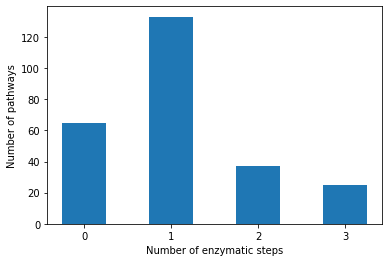

In [12]:
#plot a histogram
import matplotlib.pyplot as plt

num_chemenz_hist = duloxetine_test.values()

plt.hist(num_chemenz_hist, bins = [0,1,2,3,4],rwidth = 0.5)
plt.xticks(ticks =[0.5,1.5,2.5, 3.5], labels = [0,1,2,3])
plt.ylabel ('Number of pathways')
plt.xlabel ('Number of enzymatic steps')
plt.show()

In [10]:
duloxetine_test

{0: 0,
 1: 1,
 2: 0,
 3: 0,
 4: 1,
 5: 0,
 6: 1,
 7: 0,
 8: 0,
 9: 0,
 10: 1,
 11: 0,
 12: 1,
 13: 0,
 14: 0,
 15: 1,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 2,
 22: 2,
 23: 2,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 0,
 34: 1,
 35: 3,
 36: 3,
 37: 3,
 38: 3,
 39: 0,
 40: 0,
 41: 3,
 42: 3,
 43: 1,
 44: 3,
 45: 3,
 46: 3,
 47: 3,
 48: 3,
 49: 3,
 50: 3,
 51: 3,
 52: 3,
 53: 3,
 54: 3,
 55: 3,
 56: 3,
 57: 3,
 58: 1,
 59: 1,
 60: 2,
 61: 1,
 62: 3,
 63: 3,
 64: 1,
 65: 2,
 66: 1,
 67: 2,
 68: 3,
 69: 3,
 70: 1,
 71: 1,
 72: 1,
 73: 2,
 74: 2,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 2,
 87: 2,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 2,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 0,
 104: 0,
 105: 1,
 106: 0,
 107: 0,
 108: 1,
 109: 1,
 110: 1,
 111: 1,
 112: 1,
 113: 1,
 114: 1,
 115: 1,
 116: 0,
 117: 1,
 118: 1,
 119: 1,
 120: 1,
 121: 1,
 122: 2,
 12

In [11]:
for item in duloxetine_test.items():
    if (len(test.get_all_rxn_smiles (test.get_branch_by_ix(item[0])))==4):
        if 'C=O.CC(=O)c1cccs1.CNC>>CN(C)CCC(=O)c1cccs1' in test.get_all_rxn_smiles (test.get_branch_by_ix(item[0])):
            print ('Key:{}'.format (item[0]))

Key:95
Key:98
Key:101


In [60]:
test.get_all_rxn_smiles (test.get_branch_by_ix(95))

['CN(C)CC[C@H](Oc1cccc2ccccc12)c1cccs1>>CNCC[C@H](Oc1cccc2ccccc12)c1cccs1',
 'CN(C)CC[C@H](O)c1cccs1.Fc1cccc2ccccc12>>CN(C)CC[C@H](Oc1cccc2ccccc12)c1cccs1',
 'CN(C)CCC(=O)c1cccs1>>CN(C)CC[C@H](O)c1cccs1',
 'C=O.CC(=O)c1cccs1.CNC>>CN(C)CCC(=O)c1cccs1']

In [61]:
test.do_one_branch_detailed (95)

The reaction SMILES is:CN(C)CC[C@H](Oc1cccc2ccccc12)c1cccs1>>CNCC[C@H](Oc1cccc2ccccc12)c1cccs1
The product SMILES is: CNCC[C@H](Oc1cccc2ccccc12)c1cccs1
The reactant SMILES list is: [['CN(C)CC[C@H](Oc1cccc2ccccc12)c1cccs1'], ['CN(C)CC[C@H](O)c1cccs1', 'Fc1cccc2ccccc12']]
No enzymes applicable
The reaction SMILES is:CN(C)CC[C@H](O)c1cccs1.Fc1cccc2ccccc12>>CN(C)CC[C@H](Oc1cccc2ccccc12)c1cccs1
The product SMILES is: CN(C)CC[C@H](Oc1cccc2ccccc12)c1cccs1
The reactant SMILES list is: [['CN(C)CC[C@H](O)c1cccs1', 'Fc1cccc2ccccc12']]
No enzymes applicable
The reaction SMILES is:CN(C)CCC(=O)c1cccs1>>CN(C)CC[C@H](O)c1cccs1
The product SMILES is: CN(C)CC[C@H](O)c1cccs1
The reactant SMILES list is: [['CN(C)CCC(=O)c1cccs1'], ['C=O', 'CC(=O)c1cccs1', 'CNC']]
Enzyme name is: [('Ketone reduction', '[#6:1][#6:2]([#6:3])[#8H1:4]>>[#6:1][#6H0:2]([#6:3])=[#8:4]', 'Reduction', 'CN(C)CCC(=O)c1cccs1>>CN(C)CC[C@H](O)c1cccs1')]
The reaction SMILES is:C=O.CC(=O)c1cccs1.CNC>>CN(C)CCC(=O)c1cccs1
The product SMILES 

[[('Ketone reduction',
   '[#6:1][#6:2]([#6:3])[#8H1:4]>>[#6:1][#6H0:2]([#6:3])=[#8:4]',
   'Reduction',
   'CN(C)CCC(=O)c1cccs1>>CN(C)CC[C@H](O)c1cccs1')]]

In [70]:
test.get_all_rxn_smiles (test.get_branch_by_ix(42))

['COC(=O)NCC[C@H](Oc1cccc2ccccc12)c1cccs1>>CNCC[C@H](Oc1cccc2ccccc12)c1cccs1',
 'COC(=O)Cl.NCC[C@H](Oc1cccc2ccccc12)c1cccs1>>COC(=O)NCC[C@H](Oc1cccc2ccccc12)c1cccs1',
 'N#CC[C@H](Oc1cccc2ccccc12)c1cccs1>>NCC[C@H](Oc1cccc2ccccc12)c1cccs1',
 'Fc1cccc2ccccc12.N#CC[C@H](O)c1cccs1>>N#CC[C@H](Oc1cccc2ccccc12)c1cccs1',
 'N#CCC(=O)c1cccs1>>N#CC[C@H](O)c1cccs1']

In [38]:
duloxetine_test[95]

1

In [39]:
duloxetine_test[98]

1

In [40]:
duloxetine_test[101]

1

In [71]:
test.do_one_branch_detailed (42)

The reaction SMILES is:COC(=O)NCC[C@H](Oc1cccc2ccccc12)c1cccs1>>CNCC[C@H](Oc1cccc2ccccc12)c1cccs1
The product SMILES is: CNCC[C@H](Oc1cccc2ccccc12)c1cccs1
The reactant SMILES list is: [['COC(=O)NCC[C@H](Oc1cccc2ccccc12)c1cccs1'], ['COC(=O)Cl', 'NCC[C@H](Oc1cccc2ccccc12)c1cccs1']]
Enzyme name is: [('N-methylation', '[#6X4z1:1][Nz0:2][#6H3:3]>>[#6:1][N:2]', 'C-X bond formation', 'NCC[C@H](Oc1cccc2ccccc12)c1cccs1>>CNCC[C@H](Oc1cccc2ccccc12)c1cccs1')]
The reaction SMILES is:COC(=O)Cl.NCC[C@H](Oc1cccc2ccccc12)c1cccs1>>COC(=O)NCC[C@H](Oc1cccc2ccccc12)c1cccs1
The product SMILES is: COC(=O)NCC[C@H](Oc1cccc2ccccc12)c1cccs1
The reactant SMILES list is: [['COC(=O)Cl', 'NCC[C@H](Oc1cccc2ccccc12)c1cccs1']]
No enzymes applicable
The reaction SMILES is:N#CC[C@H](Oc1cccc2ccccc12)c1cccs1>>NCC[C@H](Oc1cccc2ccccc12)c1cccs1
The product SMILES is: NCC[C@H](Oc1cccc2ccccc12)c1cccs1
The reactant SMILES list is: [['N#CC[C@H](Oc1cccc2ccccc12)c1cccs1'], ['Fc1cccc2ccccc12', 'N#CC[C@H](O)c1cccs1']]
Enzyme name is:

[[('N-methylation',
   '[#6X4z1:1][Nz0:2][#6H3:3]>>[#6:1][N:2]',
   'C-X bond formation',
   'NCC[C@H](Oc1cccc2ccccc12)c1cccs1>>CNCC[C@H](Oc1cccc2ccccc12)c1cccs1')],
 [('Nitrile reduction',
   '[#6:1][#6X4H2:2][NX3H2:3]>>[#6:1][#6X2:2]#[NX3:3]',
   'Reduction',
   'N#CC[C@H](Oc1cccc2ccccc12)c1cccs1>>NCC[C@H](Oc1cccc2ccccc12)c1cccs1')],
 [('Ketone reduction',
   '[#6:1][#6:2]([#6:3])[#8H1:4]>>[#6:1][#6H0:2]([#6:3])=[#8:4]',
   'Reduction',
   'N#CCC(=O)c1cccs1>>N#CC[C@H](O)c1cccs1')]]

# 2. Acrylamide synthesis

Acryamide synthesis is presented as an example of the single-step biocatalysis opportunity identifier. The ASKCOS single-step predictor output was 'C=CC#N>>C=CC(N)=O'. Here, we check if this reaction is suitable for biocatalysis.

In [2]:
test = parse_askcos_output()

In [3]:
template_set = pd.read_pickle(os.getcwd()+"/retrobiocat_database.pkl")

In [4]:
test.enzymatic_step_id(template_set,'C=CC(N)=O',['C=CC#N'])

[('Nitrile hydrolysis (CONH)',
  '[#6:1][#6X3H0:2](=[O:4])[NX3H2:3]>>[#6:1][#6X2H0:2]#[NX3H0:3]',
  'Hydrolysis',
  'C=CC#N>>C=CC(N)=O')]